## Import libraries

In [1]:
!pip install galaxy-environment

In [2]:
from galaxy_environment import environment

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

## Read the dataset

In [3]:
df = pd.read_csv('SPLUS_iDR3.txt', sep=' ',usecols=['RA', 'DEC', 'PhotoZ', 'R_petro'])

## Pre analysis

**RA and Dec**

There is a discontinuity in the RA coordinate, we will deal with this later.

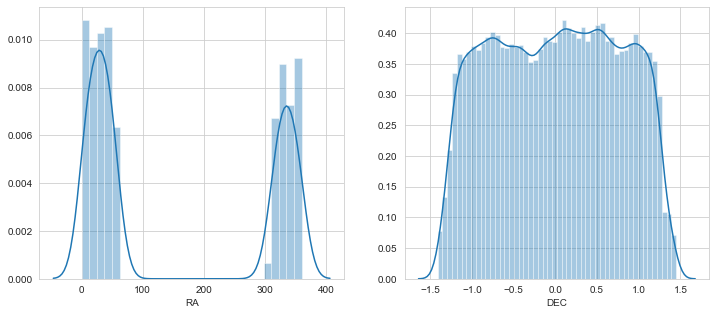

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.distplot(df['RA'], ax=ax[0])
sns.distplot(df['DEC'], ax=ax[1])

**Photometric redshift and petrosian magnitude**

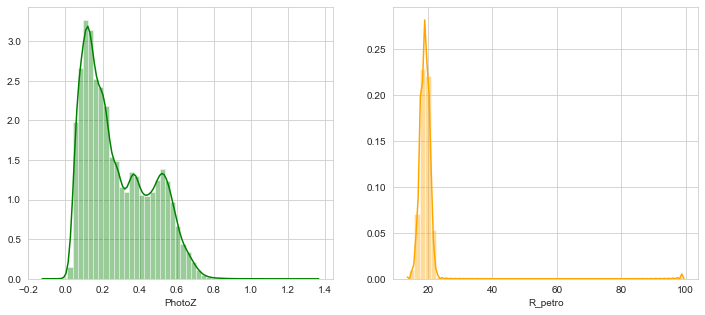

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.distplot(df['PhotoZ'], ax=ax[0], color='green')
sns.distplot(df['R_petro'], ax=ax[1], color='orange')

## Cleaning and processing

In this dataset, there are only objects classified as galaxies.

Selecting local universe and brighter objects, with petrosian magnitude less than 21.

In [6]:
zbmin, zbmax = 0.001, 0.1

sample = df[(df['PhotoZ'] >= zbmin) & (df['PhotoZ'] <= zbmax)  & (df['R_petro']<= 21)].reset_index().copy()
sample['ID'] = sample.index

Redefining RA continuity and converting coordinates to radians

In [7]:
sample['RA'].loc[sample['RA'] > 180] = (sample[sample['RA'] > 180]['RA'] - 360) 

# multiplication by g2r: conversion from degrees to radians
g2r = math.pi/180

sample['RA'] = sample['RA'] * g2r
sample['DEC'] = sample['DEC'] *g2r

sample.head()

,index,RA,DEC,R_petro,PhotoZ,ID
0,10,-0.295512,0.020728,16.610441,0.085269,0
1,28,-0.720987,-0.009775,15.534868,0.056078,1
2,32,-0.541977,-0.003696,16.997028,0.069655,2
3,48,0.089651,-0.003289,17.150537,0.076413,3
4,56,0.638124,-0.020667,16.511534,0.069815,4


## Visualization

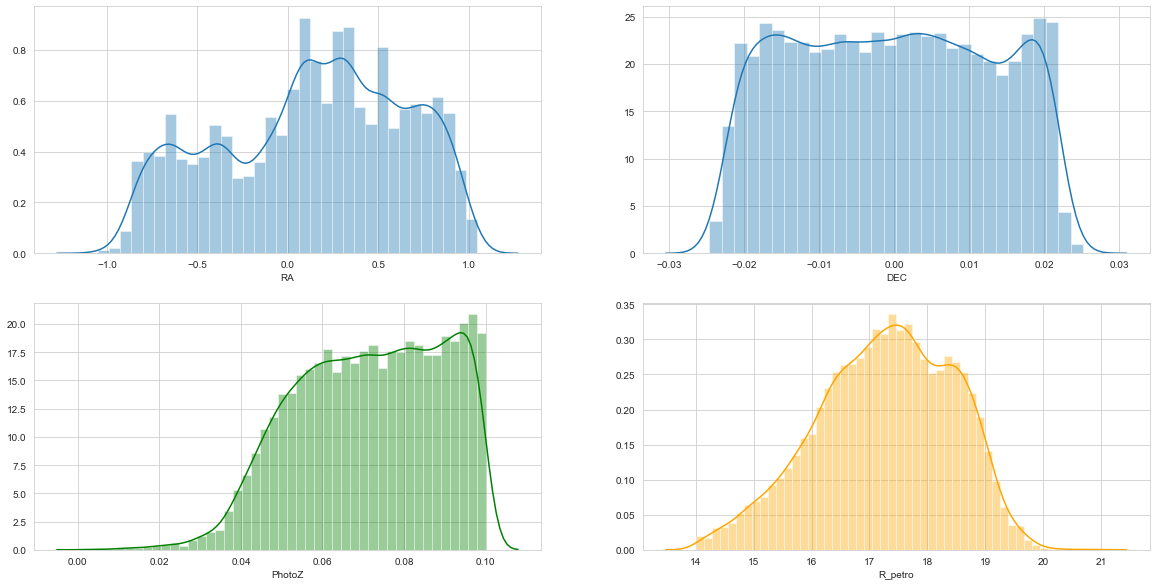

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

sns.distplot(sample['RA'], ax=ax[0][0])
sns.distplot(sample['DEC'], ax=ax[0][1])
sns.distplot(sample['PhotoZ'], ax=ax[1][0], color='green')
sns.distplot(sample['R_petro'], ax=ax[1][1], color='orange')

## K-Nearest Neighbors
We've already converted as coordinates to radians, so we'll set the parameter **degrees = False**.

We will calculate the densities for $k =$ 1, 7 and 50 neighbors.

The neighborhood around each galaxy will be delimited by $z_{galaxy} - 2\delta_z \le z_{galaxy} \le z_{galaxy} + 2\delta_z$,  \
where $\delta_z = std(z)$ by default. 

In this tutorial, we'll use $\delta_z = 0.02$

In [9]:
%%time
environment.knn(sample.head(100), ra_column='RA', dec_column = 'DEC', z_column='PhotoZ', delta_z=0.02, degrees=False, kn=[1, 7, 50])

It will be ready in less than a minute... You are lucky!
Wall time: 166 ms


,ID,ra,dec,z,sigma_k1,sigma_k7,sigma_k50,n_neighborhood
0,0,-0.295512,0.020728,0.085269,0.014395,0.000752,0.000432,92
1,1,-0.720987,-0.009775,0.056078,0.007178,0.004103,0.000325,91
2,2,-0.541977,-0.003696,0.069655,0.001450,0.003656,0.000343,99
3,3,0.089651,-0.003289,0.076413,0.037113,0.026002,0.000851,99
4,4,0.638124,-0.020667,0.069815,0.010609,0.004050,0.001035,99
...,...,...,...,...,...,...,...,...
95,95,0.051668,-0.005923,0.067561,0.013614,0.021616,0.000956,100
96,96,0.304504,0.002960,0.051443,0.045481,0.024072,0.001818,84
97,97,0.080478,0.010282,0.055530,0.066773,0.034802,0.001418,91
98,98,-0.866862,0.011523,0.040536,0.049539,0.002917,0.000297,72


## Fixed Apertures
We've already converted as coordinates to radians, so we'll set the parameter degrees = False.

We will calculate the densities for $radius =$ 0.25, 1 and 10 Mpc.

In [10]:
%%time
environment.fixedApertures(sample, ra_column='RA', dec_column = 'DEC', z_column='PhotoZ', delta_z=0.02, degrees=False, radius=[0.25, 1, 10])

Hmm, I just checked here and it seems your sample is larger than 10k rows... 

Go grab some coffee! It may take a while...
Wall time: 42.5 s


,ID,ra,dec,z,sigma_r0.25,sigma_r1,sigma_r10,n_neighborhood
0,0,-0.295512,0.020728,0.085269,5.092958,2.864789,0.684366,16502
1,1,-0.720987,-0.009775,0.056078,5.092958,2.546479,1.566085,16422
2,2,-0.541977,-0.003696,0.069655,5.092958,1.909859,1.212761,17695
3,3,0.089651,-0.003289,0.076413,20.371833,7.002817,3.148085,17506
4,4,0.638124,-0.020667,0.069815,5.092958,4.138029,1.435578,17690
...,...,...,...,...,...,...,...,...
17835,17835,-0.645698,-0.013229,0.099625,5.092958,1.273240,0.706648,12896
17836,17836,0.454513,-0.016656,0.060285,5.092958,2.864789,2.094479,17796
17837,17837,0.204272,-0.015887,0.051306,5.092958,5.411268,2.861606,14776
17838,17838,-0.450992,-0.015120,0.061669,10.185916,4.456338,1.394197,17783
